In [1]:
# Import libraries for analysis
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Reload datasets
products_df = pd.read_csv('/home/workspace/test/PRODUCTS.csv')
transactions_df = pd.read_csv("/home/workspace/test/TRANSACTION.csv")
users_df = pd.read_csv("/home/workspace/test/USER.csv")

# Standardize column names for SQLite compatibility
products_df.columns = [col.upper() for col in products_df.columns]
transactions_df.columns = [col.upper() for col in transactions_df.columns]
users_df.columns = [col.upper() for col in users_df.columns]

# Convert birth dates to datetime format
users_df["BIRTH_DATE"] = pd.to_datetime(users_df["BIRTH_DATE"], errors="coerce")

# Create an in-memory SQLite database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Load data into SQLite
products_df.to_sql("products", conn, index=False, if_exists="replace")
transactions_df.to_sql("transactions", conn, index=False, if_exists="replace")
users_df.to_sql("users", conn, index=False, if_exists="replace")


100000

## Closed-ended questions: 

### What are top 5 brands by receipts scanned among users 21 and over?

The top five brands are Nerds Candy, Dove, None, Trident and Sour Patch Kids. There is a high number of 'None' in BRAND column since BRAND can't be pulled from the Products table with missing BARCODEs in the Transaction table (~ 12% of transactions)

Assumptions made for analysis:
- A user's age is determined using the BIRTH_DATE column in USER file.
- 'Receipts scanned' is defined as the count of unique RECEIPT_ID per brand.

In [3]:
# SQL Query to identify top 5 brands by receipts scanned among users 21 and over
top_brands_query = """
SELECT p.BRAND
, COUNT(DISTINCT t.RECEIPT_ID) AS total_receipts
FROM transactions t
JOIN products p 
  ON t.BARCODE = p.BARCODE
JOIN users u
  ON t.USER_ID = u.ID
WHERE (strftime('%Y','now') - strftime('%Y',u.BIRTH_DATE)) >= 21
GROUP BY p.BRAND
ORDER BY total_receipts DESC
LIMIT 5
"""
top_brands_df = pd.read_sql(top_brands_query, conn)
top_brands_df

,BRAND,total_receipts
0,NERDS CANDY,3
1,DOVE,3
2,None,3
3,TRIDENT,2
4,SOUR PATCH KIDS,2


### What is the percentage of sales in the Health & Wellness category by generation?

The Boomer generation made up ~ 48% of the total sales at $91.91 followed by Millennials at ~ 28% and Gen X at ~ 24%.

Assumptions made for analysis:
- Users are categorized into generations based on their birth year:
    - Gen Z: Born 1997 or later (≤ 27 years old)
    - Millennials: Born 1981-1996 (28-43 years old)
    - Gen X: Born 1965-1980 (44-59 years old)
    - Boomers: Born 1946-1964 (60+ years old)
- A user's age is determined using the BIRTH_DATE column in USER file.
- If BIRTH_DATE is missing, the user is excluded from the analysis.
- Sales are derived from the FINAL_SALE column in the TRANSACTION file.
- Non-numeric or null values in FINAL_SALE are excluded from calculations.
- Sales are summed per generation and then divided by total Health & Wellness sales to compute percentages.
- Same currency ($) is used for all sales.
- Only transactions with valid BARCODE values that match products in Health & Wellness category are considered.

In [4]:
# SQL Query to calculate percentage of sales in Health & Wellness category by generation
query_health_wellness_sales_by_generation = """
WITH GenSales AS (
    SELECT CASE WHEN (strftime('%Y', 'now') - strftime('%Y', BIRTH_DATE)) <= 27 THEN 'Gen Z'
                WHEN (strftime('%Y', 'now') - strftime('%Y', BIRTH_DATE)) BETWEEN 28 AND 43 THEN 'Millennials'
                WHEN (strftime('%Y', 'now') - strftime('%Y', BIRTH_DATE)) BETWEEN 44 AND 59 THEN 'Gen X'
                ELSE 'Boomers'
           END AS generation
    , SUM(CAST(FINAL_SALE AS FLOAT)) AS health_sales
    FROM transactions t
    JOIN products p ON t.BARCODE = p.BARCODE
    JOIN users u ON t.USER_ID = u.ID
    WHERE p.CATEGORY_1 = 'Health & Wellness'
    GROUP BY generation
)
, TotalSales AS (
    SELECT SUM(health_sales) AS total_sales 
    FROM GenSales
)
SELECT g.generation
, g.health_sales
, (g.health_sales / t.total_sales) * 100 AS percentage_of_sales
FROM GenSales g, TotalSales t
ORDER BY percentage_of_sales DESC
"""

health_wellness_sales_by_generation_df = pd.read_sql(query_health_wellness_sales_by_generation, conn)
health_wellness_sales_by_generation_df

,generation,health_sales,percentage_of_sales
0,Boomers,91.91,48.460403
1,Millennials,52.16,27.501845
2,Gen X,45.59,24.037752


## Open-ended question:

### Who are Fetch's power users?

Power users are defined as user in the top 5% for:
- Receipts scanned (number of unique tranactions submitted).
- Total spending (sum of all purchases recorded in FINAL_SALE).

The general distribution of the total sales for the power users is less than a dollar to 20 dollars with some outliers reaching to 72 dollars. Here is additional analysis of power users based on generation, item category and store preferences:
- Generation Distribution of Power Users:
    - Gen X (44-59 years old) represent the largest group of power users.
    - Boomers (60+ years old) follows as the second largest group.
    - Millennials (28-43 years old) make up the smallest portion, suggesting they are less active in scanning receipts and making purchases through Fetch.
- Category Preferences by Generation: 
    - Boomers are more likely to engage with a diverse range of categories, health & wellness, snacks, alcohol, beverages and dairy.
    - Millennials and Gen Z shows stronger engagement in snack but lower total spending.
    - Millennials is the only generation with receipts scanned in the pantry category.
    - Boomers and Gen Z are the only generations with receipts scanned in the beverage category. 
    - Boomers, Millennials and Gen Z all have highest count of scanned receipts in snack category.
- Store Preferences by Generation: 
    - Millennials and Gen X users frequently shop at large national retailers and grocery chains.
    - Boomers primarily shop at traditional grocery stores and pharmacies.
    - Walmart has the highest count of power users across all generations.
    - Boomers and Gen X users shop at exclusively at CVS while Millennials shop at exclusively at Walgreens.
    - Boomers shop at exclusively at Sam's Club while Gen X shop at exclusively at Costco.

Assumptions made for analysis:
- Only distinct receipts per user are counted to avoid duplicate transactions.
- The 95th percentile threshold for total_receipts and total_sales is calculated using subqueries.
- Power users are sorted by total sales (highest first), followed by receipt scanned.

In [5]:
# SQL Query to analyze demographic, category, and store breakdown of Fetch's Power Users
query_power_users_demographics_categories_stores = """
WITH UserActivity AS (
    SELECT t.USER_ID
    , COUNT(DISTINCT t.RECEIPT_ID) AS total_receipts
    , SUM(CAST(t.FINAL_SALE AS FLOAT)) AS total_sales
    FROM transactions t
    GROUP BY t.USER_ID
), PercentileThresholds AS (
    SELECT (SELECT total_receipts FROM UserActivity ORDER BY total_receipts DESC LIMIT 1 OFFSET (SELECT COUNT(*) FROM UserActivity) * 95 / 100) AS receipts_95th
    , (SELECT total_sales FROM UserActivity ORDER BY total_sales DESC LIMIT 1 OFFSET (SELECT COUNT(*) FROM UserActivity) * 95 / 100) AS sales_95th
),
PowerUsers AS (
    SELECT ua.USER_ID
    FROM UserActivity ua, PercentileThresholds p
    WHERE ua.total_receipts >= p.receipts_95th 
    AND ua.total_sales >= p.sales_95th
)
SELECT u.GENDER
, u.STATE
, CASE WHEN (strftime('%Y', 'now') - strftime('%Y', u.BIRTH_DATE)) <= 27 THEN 'Gen Z'
       WHEN (strftime('%Y', 'now') - strftime('%Y', u.BIRTH_DATE)) BETWEEN 28 AND 43 THEN 'Millennials'
       WHEN (strftime('%Y', 'now') - strftime('%Y', u.BIRTH_DATE)) BETWEEN 44 AND 59 THEN 'Gen X'
       ELSE 'Boomers'
  END AS generation
, t.STORE_NAME
, p.CATEGORY_1
, COUNT(t.RECEIPT_ID) AS total_receipts
, SUM(CAST(t.FINAL_SALE AS FLOAT)) AS total_sales
FROM users u
JOIN PowerUsers pu 
  ON u.ID = pu.USER_ID
JOIN transactions t 
  ON u.ID = t.USER_ID
JOIN products p 
  ON t.BARCODE = p.BARCODE
GROUP BY u.GENDER
, u.STATE
, generation
, t.STORE_NAME
, p.CATEGORY_1
ORDER BY total_sales DESC
, total_receipts DESC
"""

query_power_users_demographics_categories_stores_df = pd.read_sql(query_power_users_demographics_categories_stores, conn)
query_power_users_demographics_categories_stores_df

,GENDER,STATE,generation,STORE_NAME,CATEGORY_1,total_receipts,total_sales
0,male,PA,Boomers,CVS,Health & Wellness,2,72.00
1,female,NY,Boomers,SAM'S CLUB,Snacks,4,46.72
2,female,TX,Boomers,WALMART,Alcohol,2,34.96
3,female,SC,Millennials,WALMART,Health & Wellness,2,23.94
4,female,FL,Millennials,WALMART,Snacks,4,18.60
...,...,...,...,...,...,...,...
59,female,CO,Gen X,WALMART,Beverages,2,1.52
60,female,FL,Boomers,FAMILY DOLLAR,Snacks,2,1.25
61,female,NC,Millennials,MC,Snacks,2,1.25
62,female,MO,Boomers,ST LUKES OUTPATIENT,Health & Wellness,2,1.15


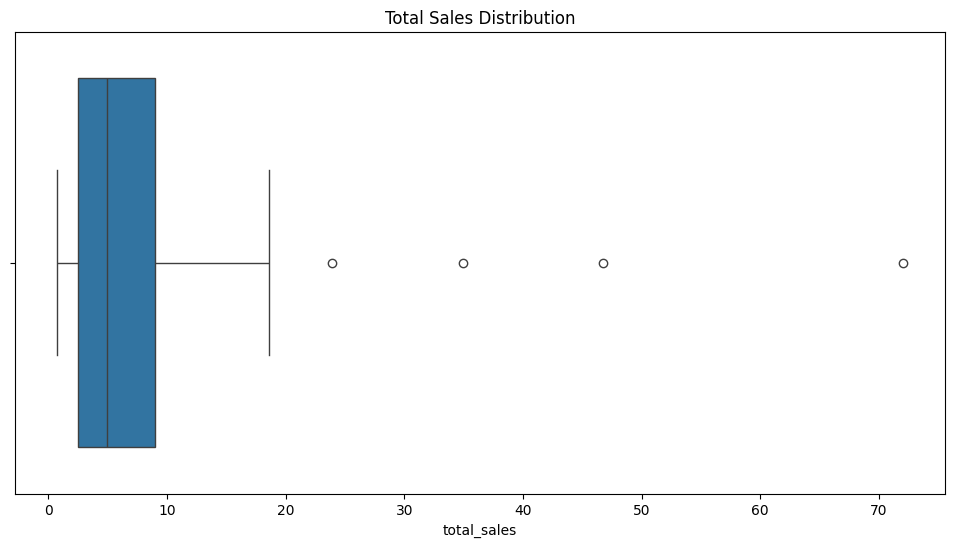

In [6]:
# Visualization for Total Sales Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=query_power_users_demographics_categories_stores_df["total_sales"].dropna())
plt.title("Total Sales Distribution")
plt.show()

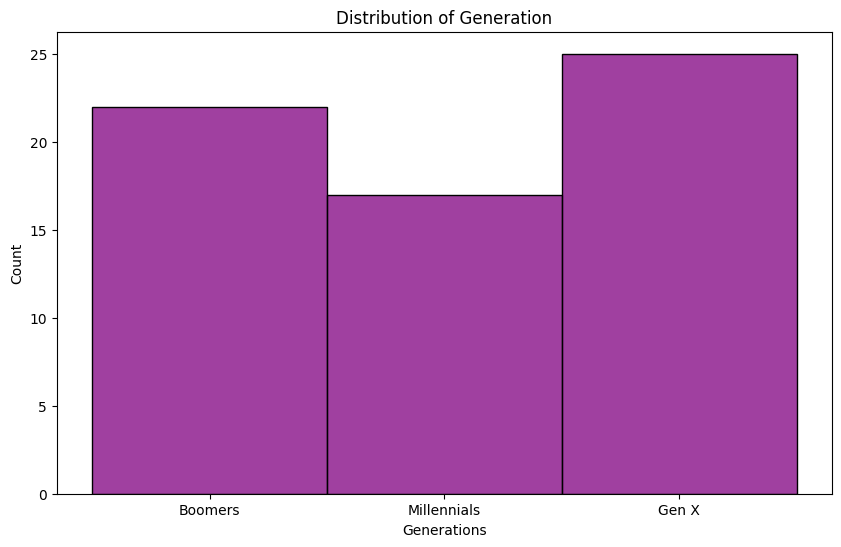

In [7]:
# Visualization for Distribution of Generation
plt.figure(figsize=(10, 6))
sns.histplot(query_power_users_demographics_categories_stores_df["generation"], color="purple")
plt.title("Distribution of Generation")
plt.xlabel("Generations")
plt.show()

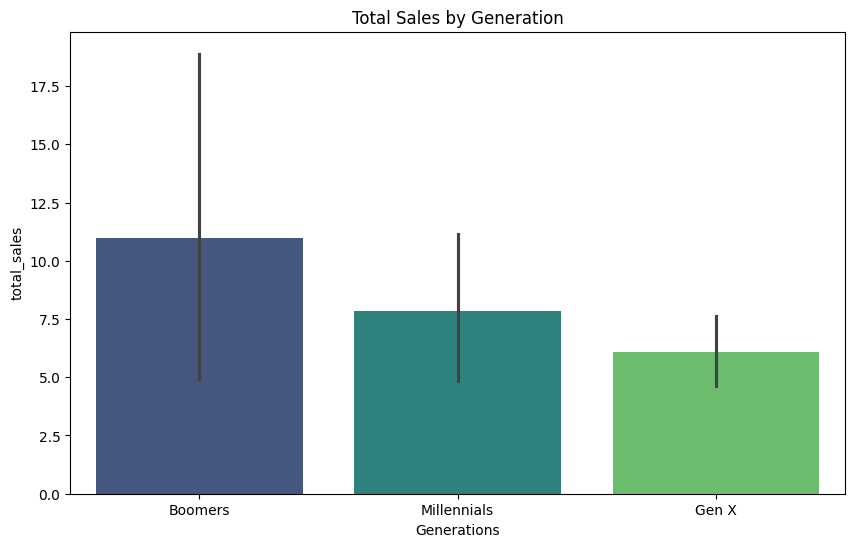

In [8]:
# Visualization for Distribution of Total Sales by Generation
plt.figure(figsize=(10, 6))
sns.barplot(x = "generation", y = "total_sales", data = query_power_users_demographics_categories_stores_df, palette="viridis")
plt.title("Total Sales by Generation")
plt.xlabel("Generations")
plt.show()

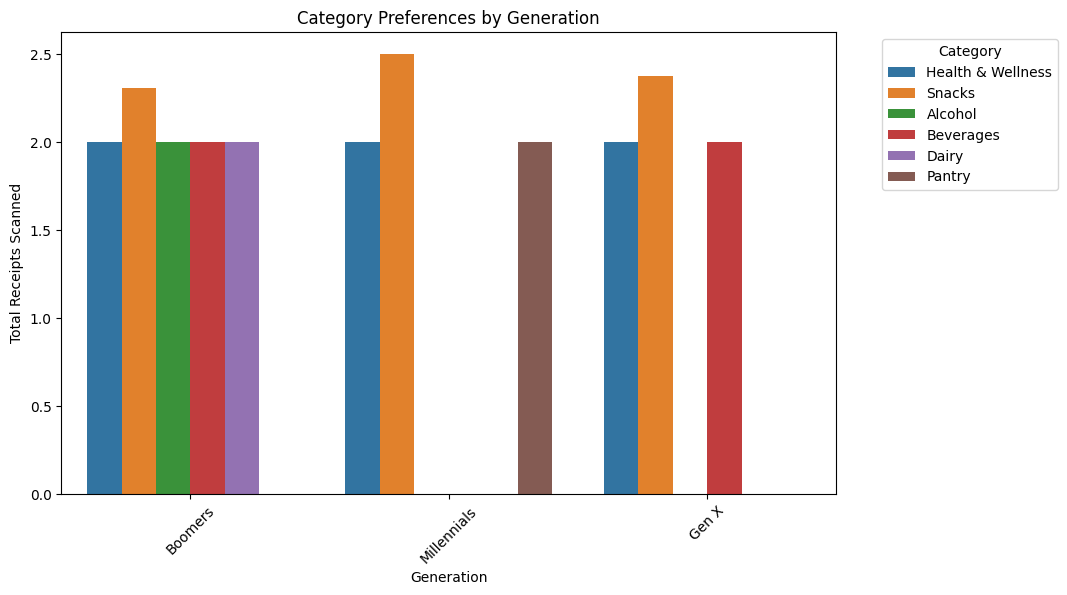

In [9]:
# Visualization for Category Preferences by Generation
plt.figure(figsize=(10, 6))
sns.barplot(x="generation", y="total_receipts", hue="CATEGORY_1", data=query_power_users_demographics_categories_stores_df, ci=None)
plt.title("Category Preferences by Generation")
plt.xlabel("Generation")
plt.ylabel("Total Receipts Scanned")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

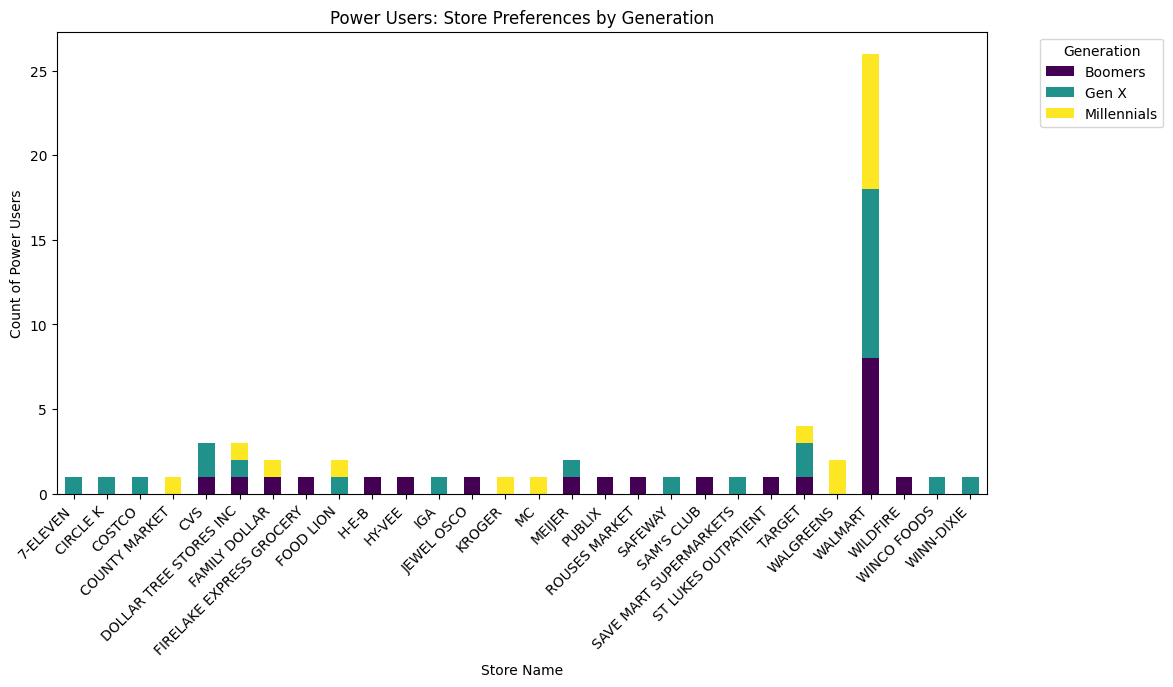

In [10]:
# Aggregate data for visualization (counting generations per store)
store_generation_counts = query_power_users_demographics_categories_stores_df.groupby(["STORE_NAME", "generation"]).size().reset_index(name="count")
# Pivot data for stacked bar chart
store_pivot = store_generation_counts.pivot(index="STORE_NAME", columns="generation", values="count").fillna(0)

# Plot stacked bar chart
store_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Power Users: Store Preferences by Generation")
plt.xlabel("Store Name")
plt.ylabel("Count of Power Users")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Generation", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show plot
plt.show()